In [0]:
from google.colab import drive

In [138]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import shutil, random
import glob
import cv2
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Input, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from scipy.misc import imresize
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
%matplotlib inline
from subprocess import check_output

In [0]:
# !pip install scipy==0.19.1
# !pip install numpy==1.17.0

In [0]:
data_dir = "drive/My Drive/Carvana_ImageMasking/train/"
# /projects/my_project/my_data"
mask_dir = "drive/My Drive/Carvana_ImageMasking/train_masks/"
all_images = os.listdir(data_dir)
test_dir = "drive/My Drive/Carvana_ImageMasking/test_set/"

In [0]:
#Train-Test Split
train_images, validation_images = train_test_split(all_images, train_size=0.8, test_size=0.2)

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


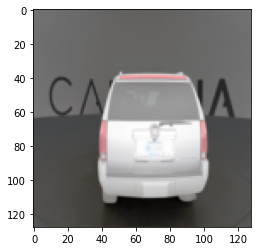

In [11]:
def grey2rgb(img):
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img.append(list(img[i][j])*3)
    new_img = np.array(new_img).reshape(img.shape[0], img.shape[1], 3)
    return new_img


# generator that we will use to read the data from the directory
def data_gen_small(data_dir, mask_dir, images, batch_size, dims):
        """
        data_dir: where the actual images are kept
        mask_dir: where the actual masks are kept
        images: the filenames of the images we want to generate batches from
        batch_size: self explanatory
        dims: the dimensions in which we want to rescale our images
        """
        while True:
            ix = np.random.choice(np.arange(len(images)), batch_size)
            imgs = []
            labels = []
            for i in ix:
                # images
                original_img = load_img(data_dir + images[i])
                resized_img = imresize(original_img, dims+[3])
                array_img = img_to_array(resized_img)/255
                imgs.append(array_img)
                
                # masks
                original_mask = load_img(mask_dir + images[i].split(".")[0] + '_mask.gif')
                resized_mask = imresize(original_mask, dims+[3])
                array_mask = img_to_array(resized_mask)/255
                labels.append(array_mask[:, :, 0])
            imgs = np.array(imgs)
            labels = np.array(labels)
            yield imgs, labels.reshape(-1, dims[0], dims[1], 1)

# example use
batch_size = 8
train_gen = data_gen_small(data_dir, mask_dir, train_images, batch_size, [128, 128])
img, msk = next(train_gen)

val_gen = data_gen_small(data_dir, mask_dir, validation_images, batch_size, [128, 128])


plt.imshow(img[0])
plt.imshow(grey2rgb(msk[0]), alpha=0.5)

In [0]:
#Function for Model architecture
def down(input_layer, filters, pool=True):
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(input_layer)
    residual = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv1)
    if pool:
        max_pool = MaxPool2D()(residual)
        return max_pool, residual
    else:
        return residual

def up(input_layer, residual, filters):
    filters=int(filters)
    upsample = UpSampling2D()(input_layer)
    upconv = Conv2D(filters, kernel_size=(2, 2), padding="same")(upsample)
    concat = Concatenate(axis=3)([residual, upconv])
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(concat)
    conv2 = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv1)
    return conv2

In [13]:
#Model Definition
filters = 64
input_layer = Input(shape = [128, 128, 3])
layers = [input_layer]
residuals = []

# Down 1, 128
d1, res1 = down(input_layer, filters)
residuals.append(res1)

filters *= 2

# Down 2, 64
d2, res2 = down(d1, filters)
residuals.append(res2)

filters *= 2

# Down 3, 32
d3, res3 = down(d2, filters)
residuals.append(res3)

filters *= 2

# Down 4, 16
d4, res4 = down(d3, filters)
residuals.append(res4)

filters *= 2

# Down 5, 8
d5 = down(d4, filters, pool=False)

# Up 1, 16
up1 = up(d5, residual=residuals[-1], filters=filters/2)

filters /= 2

# Up 2,  32
up2 = up(up1, residual=residuals[-2], filters=filters/2)

filters /= 2

# Up 3, 64
up3 = up(up2, residual=residuals[-3], filters=filters/2)

filters /= 2

# Up 4, 128
up4 = up(up3, residual=residuals[-4], filters=filters/2)

out = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(up4)

model = Model(input_layer, out)

model.summary()






Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_2[0][0]                   
_______________________________________________________________________________________

In [0]:
#Function for Metrics
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    
    y_true = tf.round(tf.reshape(y_true, [-1]))
    y_pred = tf.round(tf.reshape(y_pred, [-1]))
    
    isct = tf.reduce_sum(y_true * y_pred)
    
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

# Haven't trained using Dice_coef_loss, but can help in improving the performance
def dice_coef_loss(y_true, y_pred):
  return 1-dice_coef(y_true, y_pred)

In [0]:
#Callbacks Initilisation
filepath=F"/content/drive/My Drive/Carvana_ImageMasking/weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [42]:
#Model Training
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=[dice_coef])
model.fit_generator(train_gen, steps_per_epoch=len(train_images)//batch_size, epochs=5, validation_data = val_gen, validation_steps = len(validation_images)//batch_size, callbacks = callbacks_list,workers=1)

val_results = model.predict_generator(val_gen,steps = len(validation_images)//batch_size)
# print(val_results.shape)


Epoch 1/5


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


508/508 [==============================] - 407s 801ms/step - loss: 0.0923 - dice_coef: 0.8715 - val_loss: 0.0329 - val_dice_coef: 0.9702

Epoch 00001: val_loss improved from inf to 0.03293, saving model to /content/drive/My Drive/Carvana_ImageMasking/weights.h5
Epoch 2/5
508/508 [==============================] - 413s 813ms/step - loss: 0.0275 - dice_coef: 0.9765 - val_loss: 0.0231 - val_dice_coef: 0.9817

Epoch 00002: val_loss improved from 0.03293 to 0.02309, saving model to /content/drive/My Drive/Carvana_ImageMasking/weights.h5
Epoch 3/5
508/508 [==============================] - 400s 786ms/step - loss: 0.0218 - dice_coef: 0.9829 - val_loss: 0.0202 - val_dice_coef: 0.9846

Epoch 00003: val_loss improved from 0.02309 to 0.02018, saving model to /content/drive/My Drive/Carvana_ImageMasking/weights.h5
Epoch 4/5
508/508 [==============================] - 407s 801ms/step - loss: 0.0191 - dice_coef: 0.9859 - val_loss: 0.0197 - val_dice_coef: 0.9851

Epoch 00004: val_loss improved from 0.

RuntimeError: ignored

Epoch 1/5
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):
508/508 [==============================] - 407s 801ms/step - loss: 0.0923 - dice_coef: 0.8715 - val_loss: 0.0329 - val_dice_coef: 0.9702

Epoch 00001: val_loss improved from inf to 0.03293, saving model to /content/drive/My Drive/Carvana_ImageMasking/weights.h5
Epoch 2/5
508/508 [==============================] - 413s 813ms/step - loss: 0.0275 - dice_coef: 0.9765 - val_loss: 0.0231 - val_dice_coef: 0.9817

Epoch 00002: val_loss improved from 0.03293 to 0.02309, saving model to /content/drive/My Drive/Carvana_ImageMasking/weights.h5
Epoch 3/5
508/508 [==============================] - 400s 786ms/step - loss: 0.0218 - dice_coef: 0.9829 - val_loss: 0.0202 - val_dice_coef: 0.9846

Epoch 00003: val_loss improved from 0.02309 to 0.02018, saving model to /content/drive/My Drive/Carvana_ImageMasking/weights.h5
Epoch 4/5
508/508 [==============================] - 407s 801ms/step - loss: 0.0191 - dice_coef: 0.9859 - val_loss: 0.0197 - val_dice_coef: 0.9851

Epoch 00004: val_loss improved from 0.02018 to 0.01974, saving model to /content/drive/My Drive/Carvana_ImageMasking/weights.h5
Epoch 5/5
508/508 [==============================] - 409s 805ms/step - **loss: 0.0181 - dice_coef: 0.9872 - val_loss: 0.0181 - val_dice_coef: 0.9872**

Epoch 00005: val_loss improved from 0.01974 to 0.01810, saving model to /content/drive/My Drive/Carvana_ImageMasking/weights.h5

**Model 5 is performing optimally in both train and validation set. So using it for prediction.**

In [0]:

model.load_weights(F"/content/drive/My Drive/Carvana_ImageMasking/weights.h5")
# model.summary()

In [0]:
#Loading a sample of test data with Resizing and Rescaling
test_data=[]
for il in os.listdir('/content/drive/My Drive/Carvana_ImageMasking/test_set/'):
  # print(il)
  test_data.append(cv2.resize(cv2.imread('/content/drive/My Drive/Carvana_ImageMasking/test_set/'+il),(128,128))/255)

In [0]:
# print(test_data)

In [0]:
#to predict on the model
final_test_data=np.array(test_data)

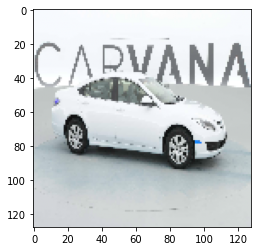

In [52]:
plt.imshow(final_test_data[0])

In [0]:
output=model.predict(final_test_data)

In [0]:
# Function to yield input in batches
def data_gen_test(data_dir, images, batch_size, dims):
        count = 0
        kl=True
        while kl:
            ix = list(range(count,count+batch_size))
            imgs = []
            img_names=[]
            labels = []
            for i in ix:
                img_names.append(images[i])
                original_img = load_img(data_dir + images[i])
                resized_img = imresize(original_img, dims+[3])
                array_img = img_to_array(resized_img)/255
                imgs.append(array_img)
            count+=batch_size
            if count+batch_size>len(images):
              kl=False  
            imgs = np.array(imgs)

            yield imgs,img_names

In [122]:
# To predict the test data in batches
output_file_names=[]
output_mask_prediction=[]
test_images_input=[]
for il,jl in data_gen_test(test_dir,os.listdir(test_dir),5,[128,128]):
  print(il.shape)
  output_file_names+=jl
  output_mask_prediction.append(model.predict(il))
  test_images_input.append(il)

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


(5, 128, 128, 3)
(5, 128, 128, 3)
(5, 128, 128, 3)
(5, 128, 128, 3)
(5, 128, 128, 3)
(5, 128, 128, 3)
(5, 128, 128, 3)
(5, 128, 128, 3)
(5, 128, 128, 3)
(5, 128, 128, 3)


In [0]:
#To form numpy arrays from the outputs
output_mask_prediction=np.concatenate(output_mask_prediction,axis=0)
test_images_input=np.concatenate(test_images_input,axis=0)

In [124]:
test_images_input.shape

(50, 128, 128, 3)

In [0]:
#to Threshold the mask
output_mask_prediction[output_mask_prediction>=0.5]=255
output_mask_prediction[output_mask_prediction<0.5]=0

In [0]:
#to Emboss masks on the output & save the output
for il in range(len(output_file_names)):
  img_recon=(test_images_input[il]*255).astype("uint8")
  
  # print(img_recon.shape)
#   params = cv2.SimpleBlobDetector_Params()
#   #masking 
  img = cv2.cvtColor(img_recon,cv2.COLOR_BGR2GRAY)
#   detector = cv2.SimpleBlobDetector_create(params)
#   # to_show=cv2.bitwise_and(img,img,mask=output[il].astype("uint8"))
# # Detect blobs 
#   keypoints = detector.detect(output[il])
#   print(keypoints)
#   im_with_keypoints = cv2.drawKeypoints(output[il], keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  
  to_show =cv2.bitwise_and(img,img,mask=output_mask_prediction[il].astype('uint8'))
  # blob_detector = cv2.SimpleBlobDetector_create()
  # to_show = blob_detector.detect(output[il])
  # img_no=1
  #for il in all_test_output:
  cv2.imwrite('/content/drive/My Drive/Carvana_ImageMasking/mask/'+'mask_'+output_file_names[il],to_show)
  img_no+=1